In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
steel_industry_energy_consumption = fetch_ucirepo(id=851) 
  
# data (as pandas dataframes) 
X = steel_industry_energy_consumption.data.features 
y = steel_industry_energy_consumption.data.targets 
  
# metadata 
print(steel_industry_energy_consumption.metadata) 
# variable information 
print(steel_industry_energy_consumption.variables) 


{'uci_id': 851, 'name': 'Steel Industry Energy Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/851/data.csv', 'abstract': 'The data is collected from a smart small-scale steel industry in South Korea.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 35040, 'num_features': 9, 'feature_types': ['Real', 'Categorical'], 'demographics': [], 'target_col': ['Load_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Mon Aug 14 2023', 'dataset_doi': '10.24432/C52G8C', 'creators': ['Sathishkumar V E', 'Changsun Shin', 'Yongyun Cho'], 'intro_paper': {'title': 'Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city', 'authors': 'Sathishkumar V E, Changsun Shin, Yongyun Cho', 'published

In [4]:
import numpy as np
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=np.number).columns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

y = LabelEncoder().fit_transform(np.ravel(y))

columnTransformer = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)]
)
X = columnTransformer.fit_transform(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

In [7]:
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [8]:
class MyDataset(Dataset):

    def __init__(self, X, y, q = 1):
        self.X = torch.tensor(X, dtype = torch.float)
        self.y = torch.tensor(y).long()
        self.q = q
    def __len__(self):
        return self.X.shape[0] - (self.q-1)
    def __getitem__(self, index):
        return (self.X[index:index+self.q], self.y[index+self.q-1])

In [9]:
train_loader = DataLoader(MyDataset(X_train, y_train, 5), batch_size = 64, shuffle = False)
test_loader = DataLoader(MyDataset(X_test, y_test, 5), batch_size = 64, shuffle = False)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

### Моя реализация RNN

In [11]:
%load_ext autoreload
%autoreload 2

In [23]:
import tests

In [ ]:
tests.test_RNNcell()

test_RNNCell ... OK


In [110]:
tests.test_RNN()

test_RNN ... OK


In [47]:
tests.test_RNN_Classifier()

test_RNN_CLassifier ... OK


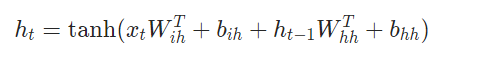

In [12]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.RNN)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [13]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

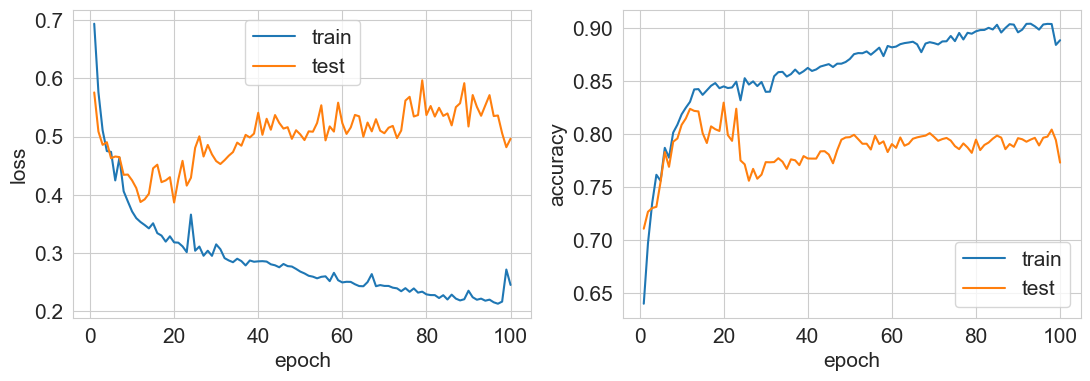

In [14]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [15]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.24549268998782595
test loss 0.4962826996204519
train accuracy 0.8886350656767561
test accuracy 0.7731910946196661


### Моя реализация LSTM

In [114]:
tests.test_LSTMcell()

test_LSTMCell ... OK


In [119]:
tests.test_LSTM()

test_LSTM ... OK


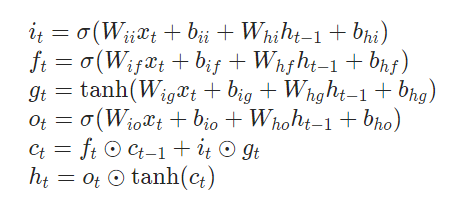

In [16]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.LSTM)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [17]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

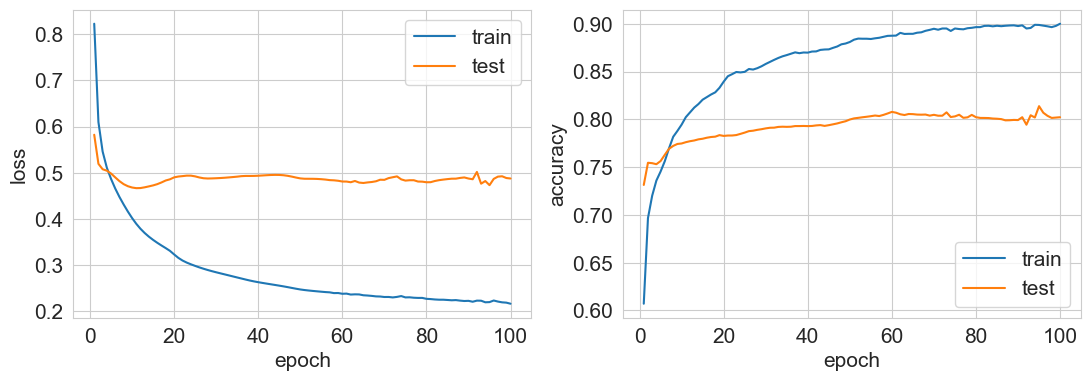

In [18]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [19]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.2162706047760018
test loss 0.4875766076479721
train accuracy 0.9001998857795546
test accuracy 0.8023048380191238


### Моя реализация GRU

In [98]:
tests.test_GRUCell()

test_GRUCell ... OK


In [62]:
tests.test_GRU()

test_GRU ... OK


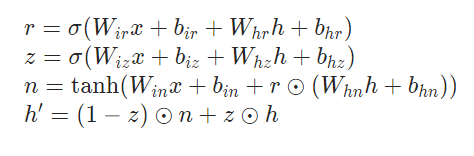

In [20]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.GRU)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [21]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

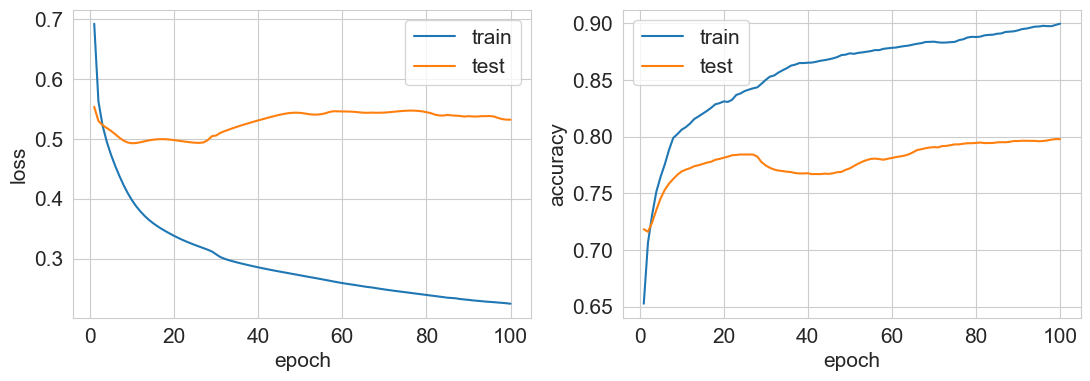

In [22]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [23]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.22475816233629659
test loss 0.5318536447149931
train accuracy 0.8996287835522558
test accuracy 0.7978093335236193
